In [1]:
# note Grakel does not seem to support Python >=3.10, Python 3.9 works fine
# you are free to remove imports that are not useful for you
from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA # to check your own implementation
from sklearn.manifold import TSNE
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math

C:\Users\Giovanni\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Some datasets, more datasets here https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets

"""
    The MUTAG dataset consists of 188 chemical compounds divided into two 
    classes according to their mutagenic effect on a bacterium. 

    The chemical data was obtained form http://cdb.ics.uci.edu and converted 
    to graphs, where vertices represent atoms and edges represent chemical 
    bonds. Explicit hydrogen atoms have been removed and vertices are labeled
    by atom type and edges by bond type (single, double, triple or aromatic).
    Chemical data was processed using the Chemistry Development Kit (v1.4).
"""

"""
    ENZYMES is a dataset of protein tertiary structures obtained from (Borgwardt et al., 2005) 
    consisting of 600 enzymes from the BRENDA enzyme database (Schomburg et al., 2004). 
    In this case the task is to correctly assign each enzyme to one of the 6 EC top-level 
    classes. 
"""

"""
    NCI1 and NCI109 represent two balanced subsets of datasets of chemical compounds screened 
    for activity against non-small cell lung cancer and ovarian cancer cell lines respectively
    (Wale and Karypis (2006) and http://pubchem.ncbi.nlm.nih.gov).
"""

dataset = fetch_dataset("MUTAG", verbose=False) # just replace by the name of the datasets you want "ENZYMES", "NCI1"
G = dataset.data
y = dataset.target
print(len(G))
print("edge list: ", G[0][0])
print("node-label dictionary: ", G[0][1])

188
edge list:  {(3, 4), (4, 3), (5, 4), (12, 13), (5, 7), (14, 13), (8, 9), (9, 8), (9, 14), (17, 15), (10, 9), (1, 6), (13, 14), (6, 5), (15, 17), (4, 5), (14, 9), (5, 6), (9, 10), (1, 2), (10, 11), (2, 1), (11, 10), (6, 1), (15, 13), (15, 16), (13, 15), (16, 15), (3, 2), (12, 11), (4, 10), (8, 7), (10, 4), (2, 3), (11, 12), (13, 12), (7, 5), (7, 8)}
node-label dictionary:  {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 2, 17: 2}


- Task 1: computing the pairwise kernels of all the graphs

In [3]:
# compute WL kernel for all graph pairs

H = 10 # number of iterations

G_cutoff = []
for i in range(len(G)):
    G_cutoff.append(G[i][:2]) # ignore edge labels

WLkernel = WeisfeilerLehman(n_iter = H) # default base graph kernel is VertexHistogram
kernel = WLkernel.fit_transform(G_cutoff)
print(kernel.shape)
print(kernel)
print("The WL tree kernel matrix has rank", np.linalg.matrix_rank(kernel))

(188, 188)
[[507 210 206 ... 189 473 289]
 [210 263 145 ... 126 260 181]
 [206 145 263 ... 129 256 186]
 ...
 [189 126 129 ... 228 231 179]
 [473 260 256 ... 231 859 361]
 [289 181 186 ... 179 361 396]]
The WL tree kernel matrix has rank 175


If we try to think of the explicit embedding space for the WL subtree kernel, it's quite easy to notice how each cell of the kernel matrix is computed as $k_{WL}(G_1,G_2) = \sum_{h=0}^{H} k_{VH}(G_1^h,G_2^h)$ , with $k_{VH}(G_1,G_2) = \sum_{i \in V_1} \sum_{j \in V_2} label(i) == label(j)$. The VertexHistogram kernel embeds each graph into a vector space of dimension equal to its number of vertices, so let's consider the graph with the maximum number of vertices $G'$ and say it has $V_{max}$ vertices, embedded into an array of dimension $V_{max}$ where every element is the label of node $i \in \{1, V_{max}\}$. Every other graph can also be expressed as a $V_{max}$ dimensional array where the extra vertices will contain a non-valid label.
The WL kernel will just contain $H$ iterations of this representation, which can be represented in a single array of dimension $H * V_{max}$, this being our explicit embedding space dimension.

Considering the rank of the $K_{WL}$ matrix, we can extrapolate ????????? So the lower bound on the dimension of this implicit embedding space for $H=10$ is $10 * V_{max}$

- Task 2: kernel visualization, PCA and t-SNE

https://nirpyresearch.com/pca-kernel-pca-explained/

In [4]:
# compute centered kernel
N = kernel.shape[0]
oneN = np.ones((N,N)) / N
kernCenter = kernel - np.matmul(oneN, kernel) - np.matmul(kernel, oneN) + np.matmul(oneN, np.matmul(kernel, oneN))

eigenvalues, eigenvectors = np.linalg.eig(kernCenter)

# sort eigenvalues and vectors
idx = np.argsort(eigenvalues)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

#save the index of our first two principal component eigenvalues
for i in reversed(range(len(eigenvalues))):
    print("Select these two eigenvalues: ev[",i,"] = ", eigenvalues[i]," ev[",i-1,"] = ", eigenvalues[i-1])
    comp1 = i
    comp2 = i-1
    break;

Select these two eigenvalues: ev[ 187 ] =  (8252.195388767284+0j)  ev[ 186 ] =  (2932.259712669472+0j)


C:\Users\Giovanni\anaconda3\lib\site-packages\matplotlib\collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


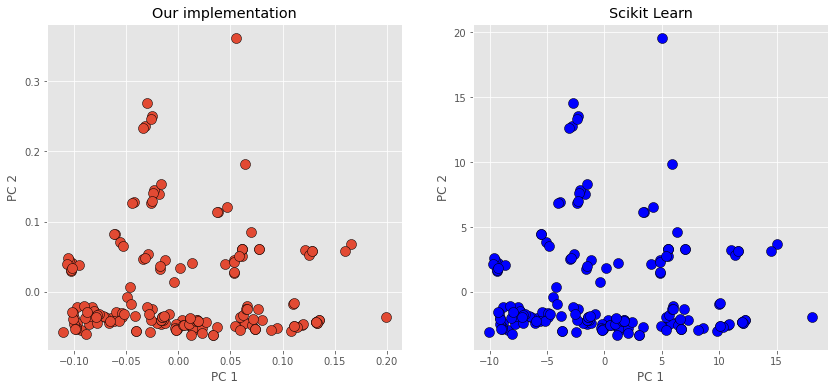

In [ ]:
# compute the kernel PCA projection on the associated eigenvectors

Xkpca = np.column_stack((eigenvectors[:,comp1], -eigenvectors[:,comp2]))

# use the sklearn method to double check

kpca = KernelPCA(kernel = 'precomputed', n_components=2)
skl_embeds = kpca.fit_transform(kernel)
 
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
 
    #plt.figure(figsize=(8,6))
    ax[0].scatter(Xkpca[:,0], Xkpca[:,1], s=100, edgecolors='k')   
    ax[0].set_xlabel('PC 1')
    ax[0].set_ylabel('PC 2')
    ax[0].set_title('Our implementation')
    
    ax[1].scatter(skl_embeds[:,0], skl_embeds[:,1], s=100, facecolor = 'b', edgecolors='k')
    ax[1].set_xlabel('PC 1')
    ax[1].set_ylabel('PC 2')
    ax[1].set_title('Scikit Learn')
    plt.show()

In [ ]:
# Compute pairwise distances of graphs

dists = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        dists[i, j] = math.sqrt(kernel[i][i] + kernel[j][j] - 2*kernel[i][j])
        
print(dists)

[[ 0.         18.70828693 18.92088793 ... 18.89444363 20.49390153
  18.02775638]
 [18.70828693  0.         15.3622915  ... 15.45962483 24.53568829
  17.23368794]
 [18.92088793 15.3622915   0.         ... 15.26433752 24.69817807
  16.94107435]
 ...
 [18.89444363 15.45962483 15.26433752 ...  0.         25.
  16.30950643]
 [20.49390153 24.53568829 24.69817807 ... 25.          0.
  23.08679276]
 [18.02775638 17.23368794 16.94107435 ... 16.30950643 23.08679276
   0.        ]]


In [7]:
# t-SNE representation

tSNE = TSNE(n_components=2, perplexity=10, n_iter=1000)
tSNE_embeddings = tSNE.fit_transform(dists)


C:\Users\Giovanni\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Giovanni\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


C:\Users\Giovanni\anaconda3\lib\site-packages\matplotlib\collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


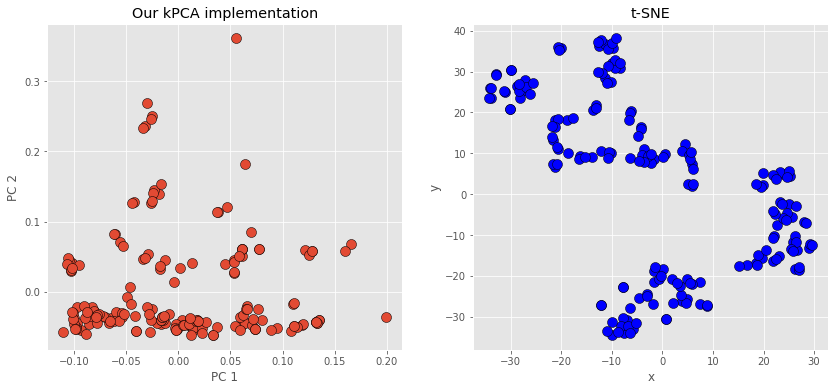

In [8]:
# comparison.... plot embeddings with PCA nad tSNE

with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
 
    #plt.figure(figsize=(8,6))
    ax[0].scatter(Xkpca[:,0], Xkpca[:,1], s=100, edgecolors='k')   
    ax[0].set_xlabel('PC 1')
    ax[0].set_ylabel('PC 2')
    ax[0].set_title('Our kPCA implementation')
    
    ax[1].scatter(tSNE_embeddings[:,0], tSNE_embeddings[:,1], s=100, facecolor = 'b', edgecolors='k')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    ax[1].set_title('t-SNE')
    plt.show()
    

- Task 3: Classification

In [9]:
# 1 baseline (constant model accuracy)
most_freq_y = max(set(y), key=list(y).count)
naiveAccuracy = list(y == most_freq_y).count(True)/N
print("Baseline accuracy: ", naiveAccuracy)

Baseline accuracy:  0.6648936170212766


In [10]:
# 2 SVM model
    
WLkernel = WeisfeilerLehman(n_iter = 3)
data_train, data_test, label_train, label_test = train_test_split(G_cutoff, y, test_size=0.2, train_size=0.8)
svm_model = SVC(C = 1e2, kernel = 'precomputed')

trainkernel = WLkernel.fit_transform(data_train) 

svm_model.fit(trainkernel, label_train) #For kernel=”precomputed”, the expected shape of X is (n_samples, n_samples).

test = WLkernel.transform(data_test)

prediction = svm_model.predict(test) #For kernel=”precomputed”, the expected shape of X is (n_samples_test, n_samples_train). ---> HOW???????
score = accuracy_score(label_test, prediction)

print(score)

0.8421052631578947


In [12]:
# 3 hyperparameter selection with GridSearch
C = (1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4)
H = (1,2,3,4,5,6,7,8,9,10)

bestC = 0
bestH = 0
bestScore = np.finfo('d').min

"""
for c in C:
    for h in H:
        score = svm_classify(G_cutoff, y, H=h, C=c)
        if score > bestScore:
            bestC = c
            bestH = h
            bestScore = score
"""

for c in C:
    for h in H:
        WLkernel = WeisfeilerLehman(n_iter = h)
        trainkernel = WLkernel.fit_transform(data_train) 
        svm_model = SVC(C = c, kernel = 'precomputed')
        scores = cross_val_score(svm_model, X=trainkernel, y = label_train, cv = 10)
        avg_score = np.mean(scores)
        if avg_score > bestScore:
            bestC = c
            bestH = h
            bestScore = avg_score
        print("C = ", c, ", H = ", h, " with accuracy score: ", avg_score)
            
print("The best parameters found are C = ", bestC, ", H = ", bestH, " with accuracy score: ", bestScore)

C =  1e-05 , H =  1  with accuracy score:  0.6866666666666668
C =  1e-05 , H =  2  with accuracy score:  0.6866666666666668
C =  1e-05 , H =  3  with accuracy score:  0.6866666666666668
C =  1e-05 , H =  4  with accuracy score:  0.6866666666666668
C =  1e-05 , H =  5  with accuracy score:  0.6866666666666668
C =  1e-05 , H =  6  with accuracy score:  0.6866666666666668
C =  1e-05 , H =  7  with accuracy score:  0.6866666666666668
C =  1e-05 , H =  8  with accuracy score:  0.6866666666666668
C =  1e-05 , H =  9  with accuracy score:  0.6866666666666668
C =  1e-05 , H =  10  with accuracy score:  0.6866666666666668
C =  0.0001 , H =  1  with accuracy score:  0.6866666666666668
C =  0.0001 , H =  2  with accuracy score:  0.6866666666666668
C =  0.0001 , H =  3  with accuracy score:  0.6866666666666668
C =  0.0001 , H =  4  with accuracy score:  0.6866666666666668
C =  0.0001 , H =  5  with accuracy score:  0.6866666666666668
C =  0.0001 , H =  6  with accuracy score:  0.6866666666666668
C